In [25]:
'''
Geolocation case study for paper
'''


import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import glob
from contextlib import contextmanager
from tqdm import tqdm
import geography
@contextmanager
def cd(newdir):
    prevdir = os.getcwd()
    os.chdir(newdir)
    try:
        yield
    finally:
        os.chdir(prevdir)


model_path = '../SSMIS/F17'

with cd(model_path):
    import sensor_info
    import local_functions
    import model_operations



In [26]:
file = '/edata1/archive/GPM/1C_F17_V7/0808/080806/1C.F17.SSMIS.XCAL2021-V.20080806-S074039-E092235.009052.V07A.HDF5'

data = local_functions.read_ssmis_l1c(file)

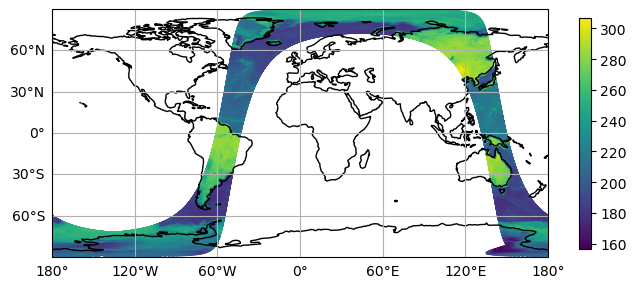

In [27]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=data['Tbs'][:,:,0], transform=ccrs.PlateCarree(), s=2.)
plt.colorbar(mappable=im, shrink=0.5)
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

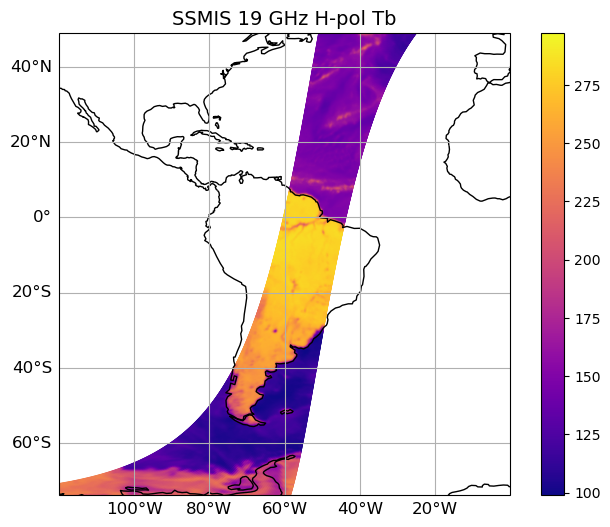

In [28]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=data['Tbs'][:,:,1], 
                transform=ccrs.PlateCarree(), s=1., cmap='plasma',)
                #vmin=180, vmax=280)
plt.colorbar(mappable=im, shrink=1)
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_title('SSMIS 19 GHz H-pol Tb', fontsize=14)
ax.coastlines()
ax.set_extent([-120,0,-60,30])
plt.show()

In [29]:
'''
Get bearing between spacecraft and center of swath
'''


with xr.open_dataset(file, group='S1/SCstatus') as f:
    sclat = f.SClatitude.values
    sclon = f.SClongitude.values

nscans,npixs = data['lat'].shape
bearing = geography.calculate_bearing(data['lat'][nscans//2,npixs//2], 
                            data['lon'][nscans//2,npixs//2], 
                            sclat[nscans//2], sclon[nscans//2])
bearing

array([69.35026], dtype=float32)

In [30]:
shifted_lat, shifted_lon = geography.great_circle_direct(data['lat'], data['lon'], 90-bearing, 2000)

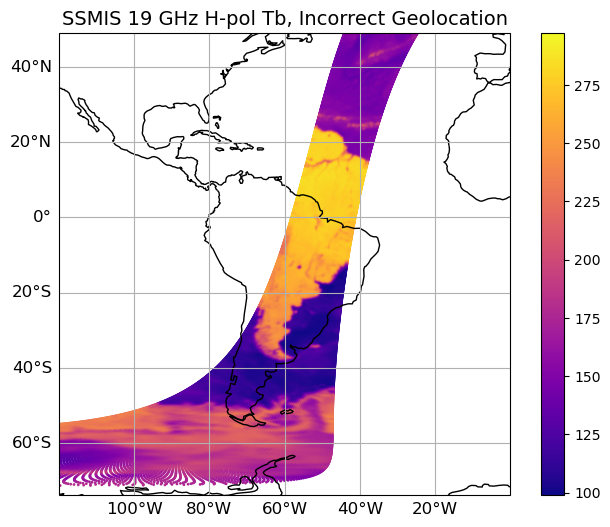

In [31]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(shifted_lon, shifted_lat, c=data['Tbs'][:,:,1],
                transform=ccrs.PlateCarree(), s=1., cmap='plasma',)
                #vmin=180, vmax=280)
plt.colorbar(mappable=im, shrink=1)
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_title('SSMIS 19 GHz H-pol Tb, Incorrect Geolocation',fontsize=14)
ax.coastlines()
ax.set_extent([-120,0,-60,30])
plt.show()

In [32]:
error_threshold = 4

Tbs = data['Tbs']
lat = data['lat']
lon = data['lon']
sctime = data['scantime']
good = ~np.isnan(lat)
# lat = lat[good]
# lon = lon[good]
# sctime = sctime[good]
# Tbs = Tbs[good]
sctime = local_functions.copy_columns(sctime, npixs)
#ngoodscans, npixs = lat.shape
nscans,npixs,nchans = Tbs.shape

with cd(model_path):
    #Load model tree
    model_tree = model_operations.load_model_tree()
    
    #Attach surface type to pixels
    sfctype = np.zeros([nscans,npixs], dtype=np.int32)
    sfctype[:] = -99
    sfctype[good] = local_functions.attach_gpm_sfctype(lat[good], lon[good], sctime[good], sensor='SSMI')
    
    #Predict Tbs
    Tbs_pred = np.zeros_like(Tbs)
    Tbs_pred[:] = np.nan
    Tbs_pred[good] = model_operations.run_predictions(Tbs[good], sfctype[good], model_tree, keep_dims=False)

    #Load in stats files
    mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
    std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
    mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
    std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)
    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)
    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    #Set flag
    mlflag = np.zeros(Tbs.shape, dtype=np.int32)
    mlflag[epsilon_hat > error_threshold] = 1

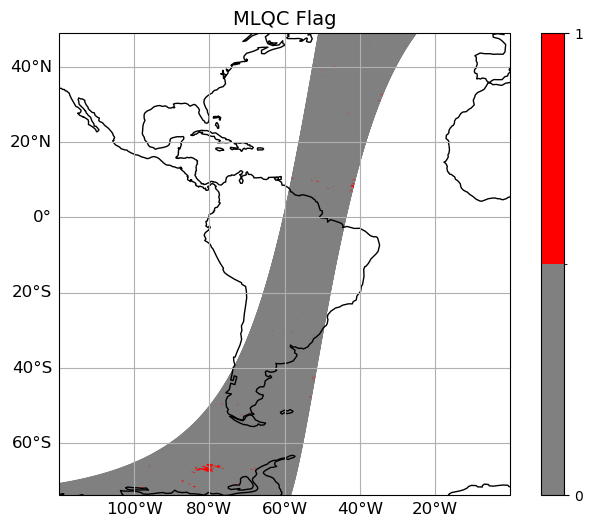

In [36]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(["gray", "red"])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(lon, lat, c=mlflag[:,:,1], 
                transform=ccrs.PlateCarree(), s=1.,
                cmap=cmap, norm=norm)
cbar = plt.colorbar(im, shrink=1, ticks=[0, 1])
cbar.ax.set_yticklabels(["0", "1"])
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_title('MLQC Flag',fontsize=14)
ax.coastlines()
ax.set_extent([-120,0,-60,30])
plt.show()

In [37]:
error_threshold = 4

Tbs = data['Tbs']
lat = data['lat']
lon = data['lon']
sctime = data['scantime']
good = ~np.isnan(lat)
# lat = lat[good]
# lon = lon[good]
# sctime = sctime[good]
# Tbs = Tbs[good]
sctime = local_functions.copy_columns(sctime, npixs)
#ngoodscans, npixs = lat.shape
nscans,npixs,nchans = Tbs.shape

with cd(model_path):
    #Load model tree
    model_tree = model_operations.load_model_tree()
    
    #Attach surface type to pixels
    sfctype = np.zeros([nscans,npixs], dtype=np.int32)
    sfctype[:] = -99
    sfctype[good] = local_functions.attach_gpm_sfctype(shifted_lat[good], shifted_lon[good], sctime[good], sensor='SSMI')
    
    #Predict Tbs
    Tbs_pred = np.zeros_like(Tbs)
    Tbs_pred[:] = np.nan
    Tbs_pred[good] = model_operations.run_predictions(Tbs[good], sfctype[good], model_tree, keep_dims=False)

    #Load in stats files
    mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
    std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
    mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
    std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)
    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)
    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    #Set flag
    mlflag = np.zeros(Tbs.shape, dtype=np.int32)
    mlflag[epsilon_hat > error_threshold] = 1

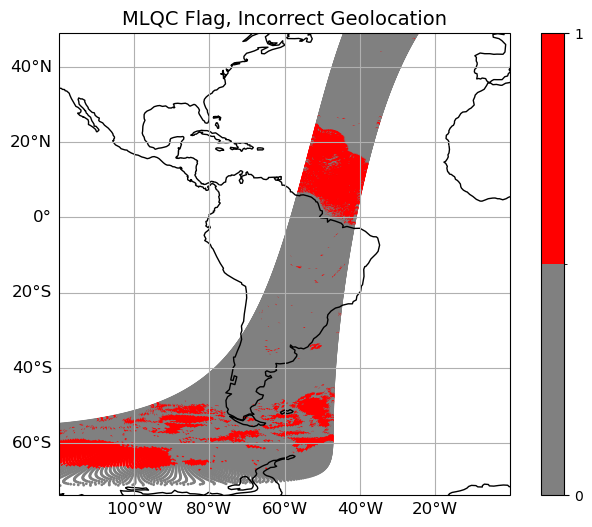

In [39]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(["gray", "red"])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(shifted_lon, shifted_lat, c=mlflag[:,:,1], 
                transform=ccrs.PlateCarree(), s=1.,
                cmap=cmap, norm=norm)
cbar = plt.colorbar(im, shrink=1, ticks=[0, 1])
cbar.ax.set_yticklabels(["0", "1"])
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_title('MLQC Flag, Incorrect Geolocation',fontsize=14)
ax.coastlines()
ax.set_extent([-120,0,-60,30])
plt.show()

In [2]:
file = '/edata1/archive/GPM/1C_F13_V7/0406/040606/1C.F13.SSMI.XCAL2018-V.20040606-S075443-E093632.047491.V07A.HDF5'

data = local_functions.read_ssmi_l1c(file)

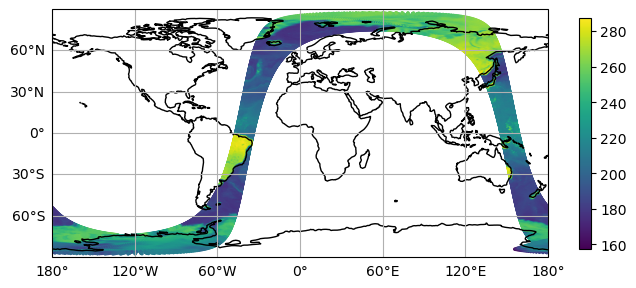

In [3]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=data['Tbs'][:,:,0], transform=ccrs.PlateCarree(), s=2.)
plt.colorbar(mappable=im, shrink=0.5)
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

In [4]:
sensor_info.channel_descriptions

['19V', '19H', '22V', '37V', '37H', '85Va', '85Ha', '85Vb', '85Hb']

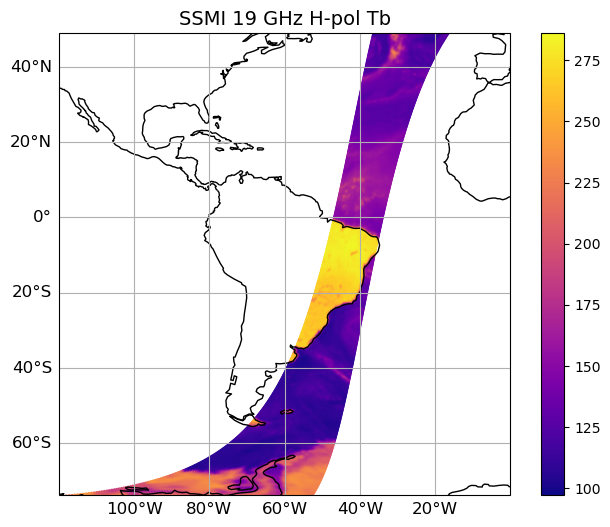

In [5]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=data['Tbs'][:,:,1], 
                transform=ccrs.PlateCarree(), s=1., cmap='plasma',)
                #vmin=180, vmax=280)
plt.colorbar(mappable=im, shrink=1)
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_title('SSMI 19 GHz H-pol Tb', fontsize=14)
ax.coastlines()
ax.set_extent([-120,0,-60,30])
plt.show()

In [6]:
'''
Get bearing between spacecraft and center of swath
'''


with xr.open_dataset(file, group='S1/SCstatus') as f:
    sclat = f.SClatitude.values
    sclon = f.SClongitude.values

nscans,npixs = data['lat'].shape
bearing = geography.calculate_bearing(data['lat'][nscans//2,npixs//2], 
                            data['lon'][nscans//2,npixs//2], 
                            sclat[nscans//2], sclon[nscans//2])
bearing

array([69.70261], dtype=float32)

In [7]:
shifted_lat, shifted_lon = geography.great_circle_direct(data['lat'], data['lon'], 90-bearing, 800)

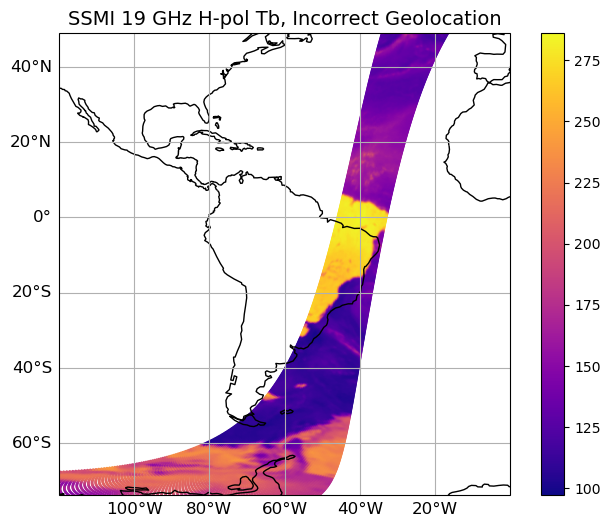

In [8]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(shifted_lon, shifted_lat, c=data['Tbs'][:,:,1],
                transform=ccrs.PlateCarree(), s=1., cmap='plasma',)
                #vmin=180, vmax=280)
plt.colorbar(mappable=im, shrink=1)
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_title('SSMI 19 GHz H-pol Tb, Incorrect Geolocation',fontsize=14)
ax.coastlines()
ax.set_extent([-120,0,-60,30])
plt.show()

In [13]:
error_threshold = 4

Tbs = data['Tbs']
lat = data['lat']
lon = data['lon']
sctime = data['scantime']
good = ~np.isnan(lat)
# lat = lat[good]
# lon = lon[good]
# sctime = sctime[good]
# Tbs = Tbs[good]
sctime = local_functions.copy_columns(sctime, npixs)
#ngoodscans, npixs = lat.shape
nscans,npixs,nchans = Tbs.shape

with cd(model_path):
    #Load model tree
    model_tree = model_operations.load_model_tree()
    
    #Attach surface type to pixels
    sfctype = np.zeros([nscans,npixs], dtype=np.int32)
    sfctype[:] = -99
    sfctype[good] = local_functions.attach_gpm_sfctype(lat[good], lon[good], sctime[good], sensor='SSMI')
    
    #Predict Tbs
    Tbs_pred = np.zeros_like(Tbs)
    Tbs_pred[:] = np.nan
    Tbs_pred[good] = model_operations.run_predictions(Tbs[good], sfctype[good], model_tree, keep_dims=False)

    #Load in stats files
    mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
    std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
    mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
    std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)
    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)
    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    #Set flag
    mlflag = np.zeros(Tbs.shape, dtype=np.int32)
    mlflag[epsilon_hat > error_threshold] = 1

In [ ]:
error_threshold = 4

Tbs = data['Tbs']
lat = data['lat']
lon = data['lon']
sctime = data['scantime']
good = ~np.isnan(lat)
# lat = lat[good]
# lon = lon[good]
# sctime = sctime[good]
# Tbs = Tbs[good]
sctime = local_functions.copy_columns(sctime, npixs)
#ngoodscans, npixs = lat.shape
nscans,npixs,nchans = Tbs.shape

with cd(model_path):
    #Load model tree
    model_tree = model_operations.load_model_tree()
    
    #Attach surface type to pixels
    sfctype = np.zeros([nscans,npixs], dtype=np.int32)
    sfctype[:] = -99
    sfctype[good] = local_functions.attach_gpm_sfctype(shifted_lat[good], shifted_lon[good], sctime[good], sensor='SSMI')
    
    #Predict Tbs
    Tbs_pred = np.zeros_like(Tbs)
    Tbs_pred[:] = np.nan
    Tbs_pred[good] = model_operations.run_predictions(Tbs[good], sfctype[good], model_tree, keep_dims=False)

    #Load in stats files
    mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
    std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
    mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
    std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)
    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)
    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    #Set flag
    mlflag = np.zeros(Tbs.shape, dtype=np.int32)
    mlflag[epsilon_hat > error_threshold] = 1

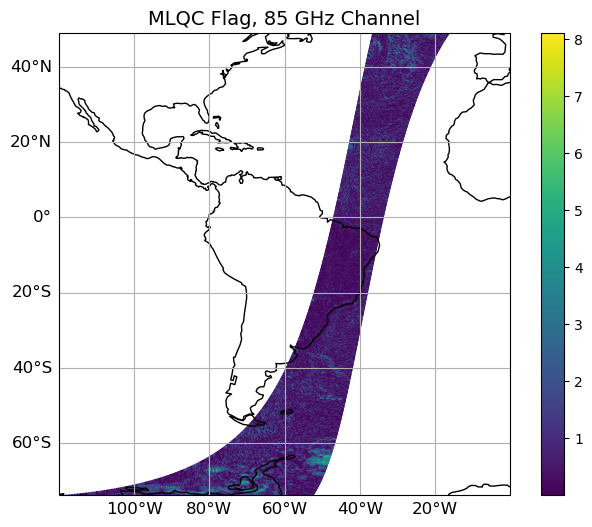

In [14]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(lon, lat, c=epsilon_hat[:,:,1], 
                transform=ccrs.PlateCarree(), s=1.)
plt.colorbar(mappable=im, shrink=1)
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_title('MLQC Flag, 85 GHz Channel',fontsize=14)
ax.coastlines()
ax.set_extent([-120,0,-60,30])
plt.show()

In [15]:
error_threshold = 4

Tbs = data['Tbs']
lat = data['lat']
lon = data['lon']
sctime = data['scantime']
good = ~np.isnan(lat)
# lat = lat[good]
# lon = lon[good]
# sctime = sctime[good]
# Tbs = Tbs[good]
sctime = local_functions.copy_columns(sctime, npixs)
#ngoodscans, npixs = lat.shape
nscans,npixs,nchans = Tbs.shape

with cd(model_path):
    #Load model tree
    model_tree = model_operations.load_model_tree()
    
    #Attach surface type to pixels
    sfctype = np.zeros([nscans,npixs], dtype=np.int32)
    sfctype[:] = -99
    sfctype[good] = local_functions.attach_gpm_sfctype(shifted_lat[good], shifted_lon[good], sctime[good], sensor='SSMI')
    
    #Predict Tbs
    Tbs_pred = np.zeros_like(Tbs)
    Tbs_pred[:] = np.nan
    Tbs_pred[good] = model_operations.run_predictions(Tbs[good], sfctype[good], model_tree, keep_dims=False)

    #Load in stats files
    mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
    std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
    mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
    std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)
    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)
    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    #Set flag
    mlflag = np.zeros(Tbs.shape, dtype=np.int32)
    mlflag[epsilon_hat > error_threshold] = 1

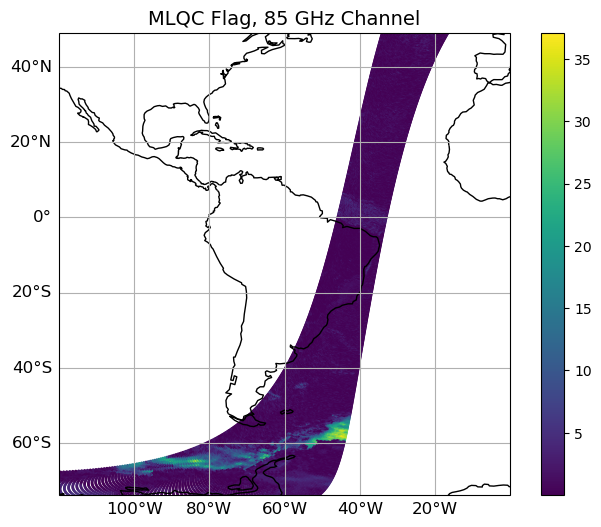

In [16]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(shifted_lon, shifted_lat, c=epsilon_hat[:,:,1], 
                transform=ccrs.PlateCarree(), s=1.)
plt.colorbar(mappable=im, shrink=1)
#plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_title('MLQC Flag, 85 GHz Channel',fontsize=14)
ax.coastlines()
ax.set_extent([-120,0,-60,30])
plt.show()